# HEAPML Project
## Random Forest

In [1]:
### GENERAL IMPORTS ###
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from itertools import cycle, combinations

### PYMATGEN/MATMINER IMPORTS ###
from matminer.featurizers import composition as cf
from matminer.featurizers.base import MultipleFeaturizer

### SKLEARN IMPORTS ###
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, cross_val_score, train_test_split, StratifiedKFold
from sklearn.feature_selection import RFECV, RFE
from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, auc, roc_curve, roc_auc_score
from sklearn.preprocessing import LabelBinarizer, label_binarize

### SKOMPTOMIZE IMPORTS ###
from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args
from skopt import gp_minimize
from skopt.plots import plot_convergence

### 1. Import Featurized Data

In [2]:
feature_calculators = MultipleFeaturizer([cf.Stoichiometry(), cf.ElementProperty.from_preset('magpie')])
feature_labels = feature_calculators.feature_labels()

alloys = pd.read_csv('./data/featurized_alloys.csv')

display(alloys)

,formula,phase,composition_obj,0-norm,2-norm,3-norm,5-norm,7-norm,10-norm,MagpieData minimum Number,...,MagpieData range GSmagmom,MagpieData mean GSmagmom,MagpieData avg_dev GSmagmom,MagpieData mode GSmagmom,MagpieData minimum SpaceGroupNumber,MagpieData maximum SpaceGroupNumber,MagpieData range SpaceGroupNumber,MagpieData mean SpaceGroupNumber,MagpieData avg_dev SpaceGroupNumber,MagpieData mode SpaceGroupNumber
0,AgAlCoCrCuNi,3,Ag1 Al1 Co1 Cr1 Cu1 Ni1,6,0.408248,0.302853,0.238495,0.215285,0.199372,13.0,...,1.548471,0.357311,0.476415,0.0,194.0,229.0,35.0,220.500000,8.833333,194.0
1,AgCoCrFeMnNi,1,Ag1 Co1 Cr1 Fe1 Mn1 Ni1,6,0.408248,0.302853,0.238495,0.215285,0.199372,24.0,...,2.110663,0.709140,0.746951,0.0,194.0,229.0,35.0,219.833333,9.555556,194.0
2,Al0.02CoCrFeMnNi,1,Al0.02 Co1 Cr1 Fe1 Mn1 Ni1,6,0.445450,0.340633,0.274847,0.250697,0.233988,13.0,...,2.110663,0.847577,0.782462,0.0,194.0,229.0,35.0,218.824701,10.617292,194.0
3,Al0.03CoCrFeMnNi,1,Al0.03 Co1 Cr1 Fe1 Mn1 Ni1,6,0.444586,0.339956,0.274300,0.250199,0.233523,13.0,...,2.110663,0.845892,0.782246,0.0,194.0,229.0,35.0,218.836978,10.605947,194.0
4,Al0.04CoCrFeMnNi,1,Al0.04 Co1 Cr1 Fe1 Mn1 Ni1,6,0.443735,0.339282,0.273756,0.249702,0.233059,13.0,...,2.110663,0.844214,0.782026,0.0,194.0,229.0,35.0,218.849206,10.594608,194.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1068,Zr2.0TiHfVNb2.0,1,Zr2 Ti1 Hf1 V1 Nb2,5,0.473804,0.381200,0.331220,0.315980,0.306266,22.0,...,0.000023,0.000003,0.000006,0.0,194.0,229.0,35.0,209.000000,17.142857,194.0
1069,ZrTiHfCuNiFe,1,Zr1 Ti1 Hf1 Cu1 Ni1 Fe1,6,0.408248,0.302853,0.238495,0.215285,0.199372,22.0,...,2.110663,0.451013,0.601344,0.0,194.0,229.0,35.0,210.166667,16.166667,194.0
1070,ZrTiHfNb0.5Mo0.5,1,Zr1 Ti1 Hf1 Nb0.5 Mo0.5,5,0.467707,0.370312,0.312720,0.292700,0.279049,22.0,...,0.000023,0.000006,0.000008,0.0,194.0,229.0,35.0,202.750000,13.125000,194.0
1071,ZrTiHfNb0.5Ta0.5,1,Zr1 Ti1 Hf1 Nb0.5 Ta0.5,5,0.467707,0.370312,0.312720,0.292700,0.279049,22.0,...,0.000023,0.000006,0.000008,0.0,194.0,229.0,35.0,202.750000,13.125000,194.0


### 2. Generate Dataset
*Formula, phase and composition_obj columns are removed from $X$*.

In [3]:
x_cols = [c for c in alloys.columns if c not in ['formula', 'phase', 'composition_obj']]

y = alloys['phase'].values
X = alloys[x_cols]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0, stratify=y)

display(X)

,0-norm,2-norm,3-norm,5-norm,7-norm,10-norm,MagpieData minimum Number,MagpieData maximum Number,MagpieData range Number,MagpieData mean Number,...,MagpieData range GSmagmom,MagpieData mean GSmagmom,MagpieData avg_dev GSmagmom,MagpieData mode GSmagmom,MagpieData minimum SpaceGroupNumber,MagpieData maximum SpaceGroupNumber,MagpieData range SpaceGroupNumber,MagpieData mean SpaceGroupNumber,MagpieData avg_dev SpaceGroupNumber,MagpieData mode SpaceGroupNumber
0,6,0.408248,0.302853,0.238495,0.215285,0.199372,13.0,47.0,34.0,28.000000,...,1.548471,0.357311,0.476415,0.0,194.0,229.0,35.0,220.500000,8.833333,194.0
1,6,0.408248,0.302853,0.238495,0.215285,0.199372,24.0,47.0,23.0,29.500000,...,2.110663,0.709140,0.746951,0.0,194.0,229.0,35.0,219.833333,9.555556,194.0
2,6,0.445450,0.340633,0.274847,0.250697,0.233988,13.0,28.0,15.0,25.948207,...,2.110663,0.847577,0.782462,0.0,194.0,229.0,35.0,218.824701,10.617292,194.0
3,6,0.444586,0.339956,0.274300,0.250199,0.233523,13.0,28.0,15.0,25.922465,...,2.110663,0.845892,0.782246,0.0,194.0,229.0,35.0,218.836978,10.605947,194.0
4,6,0.443735,0.339282,0.273756,0.249702,0.233059,13.0,28.0,15.0,25.896825,...,2.110663,0.844214,0.782026,0.0,194.0,229.0,35.0,218.849206,10.594608,194.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1068,5,0.473804,0.381200,0.331220,0.315980,0.306266,22.0,72.0,50.0,39.857143,...,0.000023,0.000003,0.000006,0.0,194.0,229.0,35.0,209.000000,17.142857,194.0
1069,6,0.408248,0.302853,0.238495,0.215285,0.199372,22.0,72.0,50.0,36.166667,...,2.110663,0.451013,0.601344,0.0,194.0,229.0,35.0,210.166667,16.166667,194.0
1070,5,0.467707,0.370312,0.312720,0.292700,0.279049,22.0,72.0,50.0,43.875000,...,0.000023,0.000006,0.000008,0.0,194.0,229.0,35.0,202.750000,13.125000,194.0
1071,5,0.467707,0.370312,0.312720,0.292700,0.279049,22.0,73.0,51.0,47.750000,...,0.000023,0.000006,0.000008,0.0,194.0,229.0,35.0,202.750000,13.125000,194.0


### 3. Train Model
`random_state` parameter is set to 0 in order to ensure reproducibility of results.

In [4]:
rf = RandomForestClassifier(random_state=0, n_jobs=-1)

rf.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=0)

### 4. Evaluate Model

In [5]:
y_pred = rf.predict(X_test)

print('Precision: %.6f' % precision_score(y_test, y_pred, average='weighted'))
print('Recall: %.6f' % recall_score(y_test, y_pred, average='weighted'))
print('F1: %.6f' % f1_score(y_test, y_pred, average='weighted'))

Precision: 0.728340
Recall: 0.729577
F1: 0.728928


### 5. Feature Selection

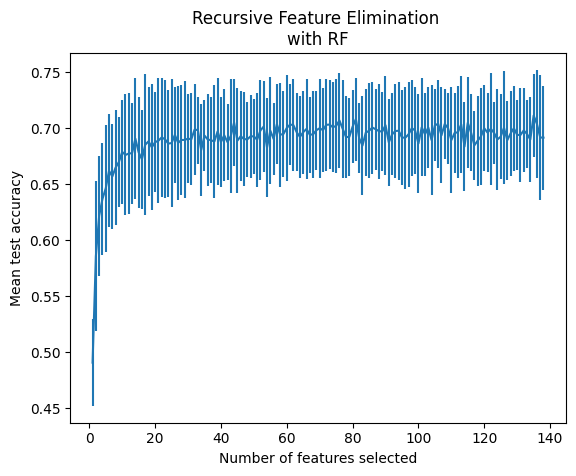

In [6]:
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
rf = RandomForestClassifier(random_state=0, n_jobs=-1)

rfecv = RFECV(estimator=rf, cv=cv, scoring="f1_weighted", n_jobs=-1)
rfecv.fit(X_train, y_train)

selected_features = rfecv.get_feature_names_out()

list(sorted(zip(range(1, 139), rfecv.cv_results_["mean_test_score"]), key=lambda x: x[1], reverse=True))[:10]

n_scores = len(rfecv.cv_results_["mean_test_score"])
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Mean test accuracy")
plt.errorbar(
    range(1, n_scores + 1),
    rfecv.cv_results_["mean_test_score"],
    yerr=rfecv.cv_results_["std_test_score"],
)
plt.title("Recursive Feature Elimination \nwith RF")
plt.savefig("graphs/rfecv_rf.png")
plt.show()

### 6. Regenerate Dataset

In [7]:
rfe = RFE(estimator=rf, n_features_to_select=28, step=1)
rfe.fit(X_train, y_train)

selected_features = rfe.get_feature_names_out()

x_cols = [c for c in alloys.columns if c in selected_features]

y = alloys['phase'].values
X = alloys[x_cols]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0, stratify=y)

### 7. Retrain Model

In [8]:
rf = RandomForestClassifier(random_state=0, n_jobs=-1)

rf.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=0)

### 8. Re-evaluate Model

In [9]:
y_pred = rf.predict(X_test)

print('Precision: %.6f' % precision_score(y_test, y_pred, average='weighted'))
print('Recall: %.6f' % recall_score(y_test, y_pred, average='weighted'))
print('F1: %.6f' % f1_score(y_test, y_pred, average='weighted'))

Precision: 0.726488
Recall: 0.729577
F1: 0.727192


### 9. Tune Hyperparameters

In [10]:
space = [Integer(10, 10**3, 'log-uniform', name='n_estimators'), 
         Integer(1, 10, 'log-uniform', name='max_depth'), 
         Categorical(['sqrt', 'log2', None], name='max_features'),
         Integer(2, 10, 'uniform', name='min_samples_split'), 
         Integer(1, 5, 'uniform', name='min_samples_leaf'),
         Categorical([True, False], name='bootstrap')]

In [11]:
@use_named_args(space)
def objective(**params):
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
    rf = RandomForestClassifier(random_state=0, n_jobs=-1)
    rf.set_params(**params)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    score = f1_score(y_test, y_pred, average='weighted')
    return 1.0 - score

class tqdm_skopt(object):
    def __init__(self, **kwargs):
        self._bar = tqdm(**kwargs)
        
    def __call__(self, res):
        self._bar.update()

c:\Users\sarmi\Documents\Projects\heapml\.venv\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\sarmi\Documents\Projects\heapml\.venv\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\sarmi\Documents\Projects\heapml\.venv\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\sarmi\Documents\Projects\heapml\.venv\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\sarmi\Documents\Projects\heapml\.venv\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objectiv

[34, 10, 'log2', 6, 1, False]
0.7339260247566081


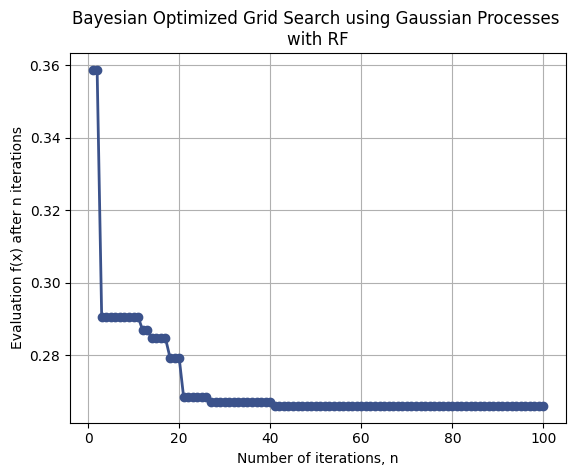

In [12]:
n_calls = 100
result = gp_minimize(objective,
                     space,
                     n_calls=n_calls,
                     random_state=0)

print(result.x)
print(1-result.fun)
plot_convergence(result)
plt.xlabel("Number of iterations, n")
plt.ylabel("Evaluation f(x) after n iterations")
plt.title("Bayesian Optimized Grid Search using Gaussian Processes \nwith RF")
plt.savefig("graphs/gp_rf.png")

### 10. Retrain and Evaluate Model

Precision: 0.732049
Recall: 0.738028
F1: 0.733926


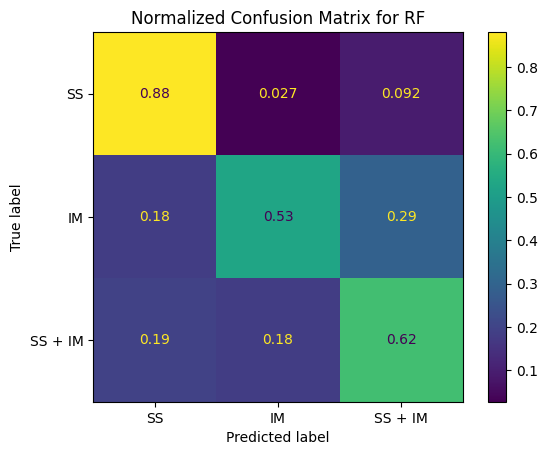

In [13]:
rf = RandomForestClassifier(n_estimators=34,
                            max_depth=10,
                            max_features="log2",
                            min_samples_split=6,
                            min_samples_leaf=1,
                            bootstrap=False,
                            random_state=0)

rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

print('Precision: %.6f' % precision_score(y_test, y_pred, average='weighted'))
print('Recall: %.6f' % recall_score(y_test, y_pred, average='weighted'))
print('F1: %.6f' % f1_score(y_test, y_pred, average='weighted'))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, normalize='true', display_labels=['SS', 'IM', 'SS + IM'])
plt.title("Normalized Confusion Matrix for RF")
plt.savefig("graphs/cm_rf.png")

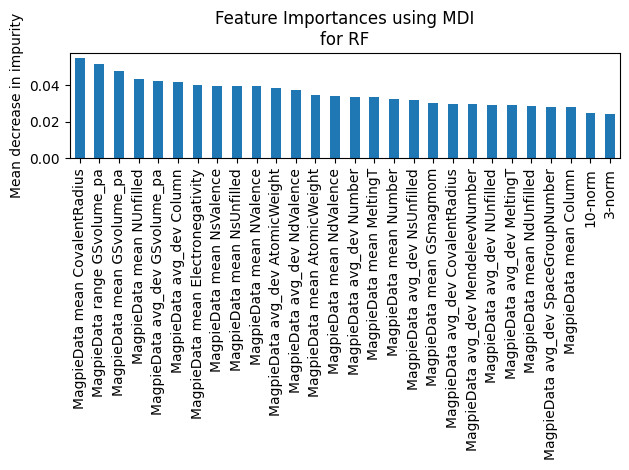

In [14]:
feature_names = [f"{i}" for i in (X.columns)]

importances = rf.feature_importances_
forest_importances = pd.Series(importances, index=feature_names).sort_values(axis=0, ascending=False)

fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax)
ax.set_title("Feature Importances using MDI\nfor RF")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()
plt.savefig("graphs/fi_rf.png")

In [15]:
class_labels = ["SS", "IM", "SS+IM"]
label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)

fpr_grid = np.linspace(0.0, 1.0, 1000)

pair_list = list(combinations(np.unique(y), 2))

pair_scores = []
mean_tpr = dict()

for ix, (label_a, label_b) in enumerate(pair_list):

    a_mask = y_test == label_a
    b_mask = y_test == label_b
    ab_mask = np.logical_or(a_mask, b_mask)

    a_true = a_mask[ab_mask]
    b_true = b_mask[ab_mask]

    idx_a = np.flatnonzero(label_binarizer.classes_ == label_a)[0]
    idx_b = np.flatnonzero(label_binarizer.classes_ == label_b)[0]

    fpr_a, tpr_a, _ = roc_curve(a_true, y_score[ab_mask, idx_a])
    fpr_b, tpr_b, _ = roc_curve(b_true, y_score[ab_mask, idx_b])

    mean_tpr[ix] = np.zeros_like(fpr_grid)
    mean_tpr[ix] += np.interp(fpr_grid, fpr_a, tpr_a)
    mean_tpr[ix] += np.interp(fpr_grid, fpr_b, tpr_b)
    mean_tpr[ix] /= 2
    mean_score = auc(fpr_grid, mean_tpr[ix])
    pair_scores.append(mean_score)

macro_roc_auc_ovo = roc_auc_score(
    y_test,
    y_score,
    multi_class="ovo",
    average="weighted",
)

ovo_tpr = np.zeros_like(fpr_grid)

fig, ax = plt.subplots(figsize=(6, 6))
for ix, (label_a, label_b) in enumerate(pair_list):
    ovo_tpr += mean_tpr[ix]
    plt.plot(
        fpr_grid,
        mean_tpr[ix],
        label=f"Mean {class_labels[label_a-1]} vs {class_labels[label_b-1]} (AUC = ~{pair_scores[ix]:.2f})",
    )

ovo_tpr /= sum(1 for pair in enumerate(pair_list))

plt.plot(
    fpr_grid,
    ovo_tpr,
    label=f"OvO weighted-average (AUC = ~{macro_roc_auc_ovo:.2f})",
    linestyle=":",
    linewidth=4,
)
plt.plot([0, 1], [0, 1], "k--", label="Chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("OvO ROC curves\nfor RF model")
plt.legend()
plt.savefig("graphs/ovo_roc_rf.png")
plt.show()

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed